In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download -d mervecayli/detection-of-down-syndrome-in-children

 30% 9.00M/30.5M [00:00<00:00, 85.6MB/s]
100% 30.5M/30.5M [00:00<00:00, 162MB/s] 


In [ ]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from zipfile import ZipFile
SEED = 15
BATCH_SIZE = 8
IMAGE_SIZE = (224, 224)

import os
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
file_name = "/content/detection-of-down-syndrome-in-children.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm

In [ ]:
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))

    return full_path


data_healthy = create_images_list('/content/healty/healty')
data_down = create_images_list('/content/downSyndorme/downSyndrome')


# look-up table
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
def create_img_label_sample(data, index):

    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]

    return img, label


def create_random_samples(data):

    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]

    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)

    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)


    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')

    plt.show()

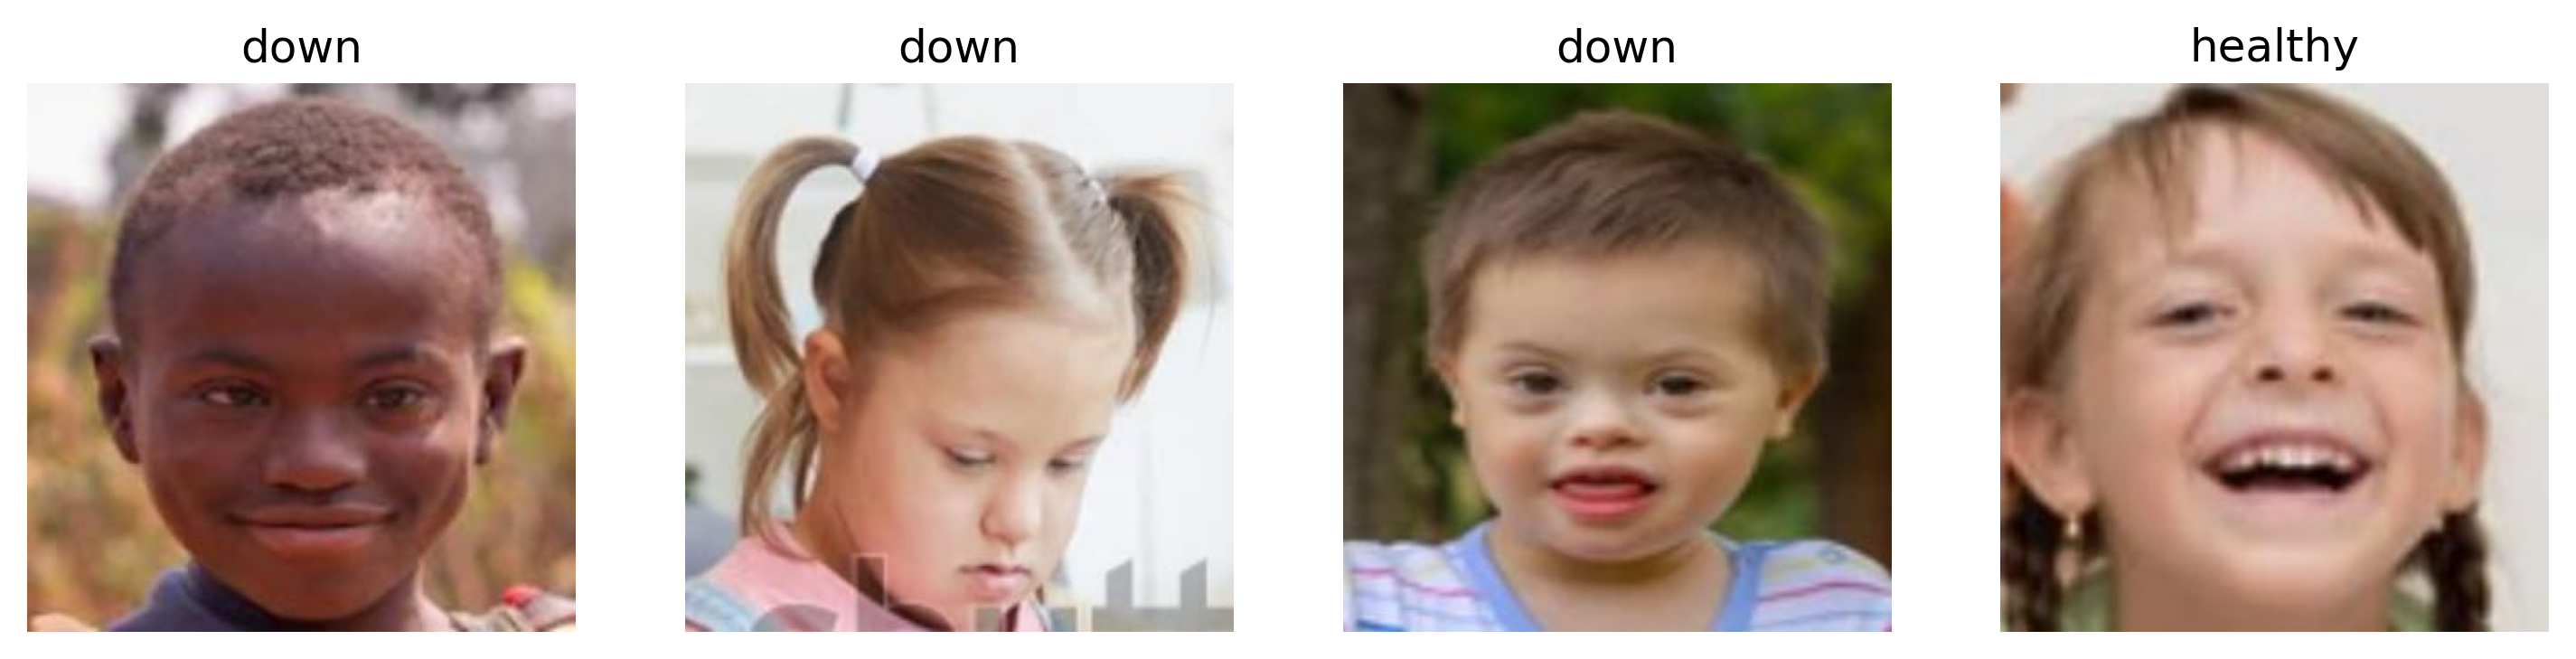

In [ ]:
create_random_samples(data_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_df['img'], data_df['label'], test_size=0.15, random_state=SEED)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_df,
    x_col="img",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=SEED,
)


Found 2999 validated image filenames.


In [ ]:

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"img": X_val, "label": y_val}),
    x_col="img",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=SEED,
    shuffle=False,
    subset="validation"  # Specify that this is the validation subset
)

Found 0 validated image filenames.


In [ ]:
base_model = VGG16(
    include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("vgg16_model.h5", save_best_only=True, verbose=1)


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,  # Use the validation generator
    callbacks=[early_stopping, model_checkpoint],
)


Epoch 1/5
375/375 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6339

375/375 [==============================] - 1732s 5s/step - loss: 0.6414 - accuracy: 0.6339
Epoch 2/5
375/375 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.6882

375/375 [==============================] - 1740s 5s/step - loss: 0.5793 - accuracy: 0.6882
Epoch 3/5
287/375 [=====================>........] - ETA: 6:47 - loss: 0.5510 - accuracy: 0.7176

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({"img": X_test, "label": y_test}),
    x_col="img",
    y_col="label",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    seed=SEED,
    shuffle=False,
)

Found 450 validated image filenames.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


57/57 [==============================] - 265s 5s/step - loss: 0.4746 - accuracy: 0.7689
Test Accuracy: 0.7688888907432556


In [ ]:
y_pred = model.predict(test_generator).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)

57/57 [==============================] - 259s 5s/step


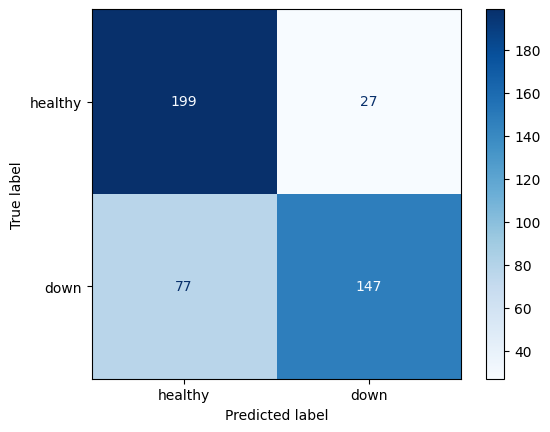

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy", "down"])
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Assuming you have already predicted the labels for the test set
# using the model and stored them in y_pred_binary and y_test

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

# Calculate sensitivity (recall)
# Sensitivity measures the true positive rate
# It is also known as recall or the proportion of true positives out of all actual positives
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("Sensitivity (Recall):", sensitivity)

# Calculate specificity
# Specificity measures the true negative rate
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Specificity:", specificity)

# Calculate precision
# Precision is the proportion of true positives out of all predicted positives
precision = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("Precision:", precision)

# Generate a classification report
# This report provides precision, recall, F1-score, and support for each class
class_report = classification_report(y_test, y_pred_binary, target_names=["healthy", "down"])
print("Classification Report:\n", class_report)


Accuracy: 0.7688888888888888
F1 Score: 0.7386934673366835
Sensitivity (Recall): 0.65625
Specificity: 0.8805309734513275
Precision: 0.8448275862068966
Classification Report:
               precision    recall  f1-score   support

     healthy       0.72      0.88      0.79       226
        down       0.84      0.66      0.74       224

    accuracy                           0.77       450
   macro avg       0.78      0.77      0.77       450
weighted avg       0.78      0.77      0.77       450

